In [12]:
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import numpy as np

os.chdir("/Users/ratikiyer/Documents/Quant/IMC/imc_trading_2024")

In [3]:
orderbook_data = pd.read_csv("./data/round-2-island-data-bottle/orderbook_round_2_day_1.csv", delimiter=";")
conversion_data_d1 = pd.read_csv("./data/round-2-island-data-bottle/prices_round_2_day_1.csv", delimiter=";")
conversion_data_d0 = pd.read_csv("./data/round-2-island-data-bottle/prices_round_2_day_0.csv", delimiter=";")

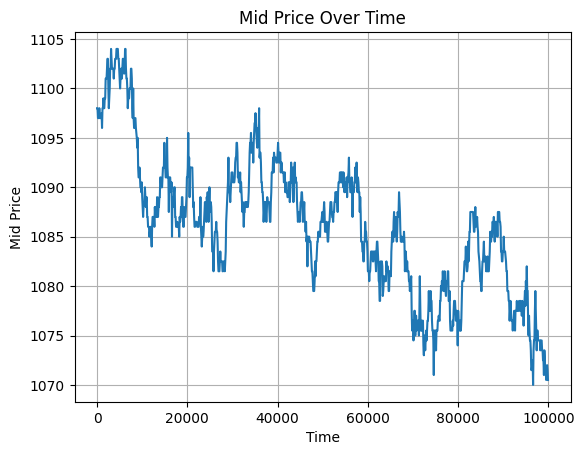

In [4]:
# Plot orderbook_data ORCHIDS prices
####################################
orchid_orders = orderbook_data[(orderbook_data["product"] == "ORCHIDS")]
plt.plot(orchid_orders['timestamp'], orchid_orders['mid_price'])
plt.title('Mid Price Over Time')
plt.xlabel('Time')
plt.ylabel('Mid Price')
plt.grid(True) 
plt.show()

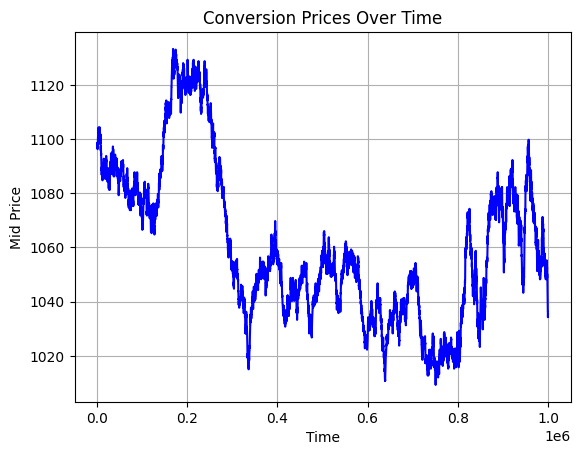

In [5]:
# Plot conversion_data_d1 ORCHIDS prices
####################################
plt.plot(conversion_data_d1['timestamp'], conversion_data_d1['ORCHIDS'], color = 'blue', label = 'price')
# plt.plot(conversion_data_d1['timestamp'], conversion_data_d1['SUNLIGHT'], color = 'red', label = 'sunlight')
# plt.plot(conversion_data_d1['timestamp'], conversion_data_d1['HUMIDITY'], color = 'yellow', label = 'humidity')
plt.title('Conversion Prices Over Time')
plt.xlabel('Time')
plt.ylabel('Mid Price')
plt.grid(True) 
plt.show()

In [23]:
# Create lagged price features
orderbook_columns = ['timestamp', 'bid_price_1', 'bid_volume_1', 'ask_price_1', 'ask_volume_1', 'mid_price']
model_data = orchid_orders[orderbook_columns].copy()

model_data['sunlight'] = conversion_data_d1["SUNLIGHT"]
model_data['humidity'] = conversion_data_d1["HUMIDITY"]
model_data['import_tariff'] = conversion_data_d1["IMPORT_TARIFF"]
model_data['export_tariff'] = conversion_data_d1["EXPORT_TARIFF"]
model_data['transport_fees'] = conversion_data_d1["TRANSPORT_FEES"]

for i in range(1, 5):
    model_data.loc[:, f'price_lag_{i}'] = model_data['mid_price'].shift(i)
model_data.dropna(inplace=True)

exog_vars = model_data[['price_lag_1', 'price_lag_2', 'price_lag_3', 'price_lag_4', 'sunlight', 'humidity']]
model_data.head()

,timestamp,bid_price_1,bid_volume_1,ask_price_1,ask_volume_1,mid_price,sunlight,humidity,import_tariff,export_tariff,transport_fees,price_lag_1,price_lag_2,price_lag_3,price_lag_4
13,400,1093,10,1101,10,1097.0,2096.7683,70.292336,-5.0,9.5,0.9,1097.0,1097.0,1098.0,1098.0
16,500,1094,5,1102,5,1098.0,2096.0005,70.358894,-5.0,9.5,0.9,1097.0,1097.0,1097.0,1098.0
19,600,1093,10,1101,10,1097.0,2095.2240,70.425110,-5.0,9.5,0.9,1098.0,1097.0,1097.0,1097.0
23,700,1093,6,1101,6,1097.0,2094.1765,70.512886,-5.0,9.5,0.9,1097.0,1098.0,1097.0,1097.0
25,800,1093,10,1101,10,1097.0,2093.6472,70.556550,-5.0,9.5,0.9,1097.0,1097.0,1098.0,1097.0


In [29]:
model = SARIMAX(model_data['mid_price'], 
                order=(1, 1, 1),
                seasonal_order=(1, 1, 1, 2),
                exog=exog_vars)

results = model.fit(maxiter=10)
model_data['predicted_price'] = results.predict()
model_data.head()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invert

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.77930D+00    |proj g|=  7.76316D-02

At iterate    5    f=  1.68698D+00    |proj g|=  1.32566D-01

At iterate   10    f=  1.65484D+00    |proj g|=  5.57900D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     10     16      1     0     0   5.579D-02   1.655D+00
  F =   1.6548431119404494     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,timestamp,bid_price_1,bid_volume_1,ask_price_1,ask_volume_1,mid_price,sunlight,humidity,import_tariff,export_tariff,transport_fees,price_lag_1,price_lag_2,price_lag_3,price_lag_4,predicted_price
13,400,1093,10,1101,10,1097.0,2096.7683,70.292336,-5.0,9.5,0.9,1097.0,1097.0,1098.0,1098.0,389.293179
16,500,1094,5,1102,5,1098.0,2096.0005,70.358894,-5.0,9.5,0.9,1097.0,1097.0,1097.0,1098.0,1097.037652
19,600,1093,10,1101,10,1097.0,2095.2240,70.425110,-5.0,9.5,0.9,1098.0,1097.0,1097.0,1097.0,1452.161628
23,700,1093,6,1101,6,1097.0,2094.1765,70.512886,-5.0,9.5,0.9,1097.0,1098.0,1097.0,1097.0,1098.488072
25,800,1093,10,1101,10,1097.0,2093.6472,70.556550,-5.0,9.5,0.9,1097.0,1097.0,1098.0,1097.0,1095.331260
